# Setup

In [9]:
import os
import sys
from pathlib import Path
import random
import numpy as np
import pickle
from typing import List

# Add the src directory to Python path
olmo_core_path = Path.cwd() / "src"
if olmo_core_path.exists():
    sys.path.insert(0, str(olmo_core_path))

from olmo_core.data import (
    NumpyDataLoaderConfig,
    NumpyDatasetConfig,
    NumpyDatasetType,
    TokenizerConfig,
)
from olmo_core.data.numpy_dataset import (
    VSLCurriculumType,
    VSLCurriculumConfig,
)


In [10]:
# Set your new cache base directory (change this to your preferred location)
cache_base = "/home/joberant/NLP_2425b/yoavbaron"

# Set all relevant Hugging Face cache directories
os.environ["HF_HOME"] = cache_base
os.environ["TRANSFORMERS_CACHE"] = os.path.join(cache_base, "transformers")
os.environ["HF_DATASETS_CACHE"] = os.path.join(cache_base, "datasets")
os.environ["HF_TOKENIZERS_CACHE"] = os.path.join(cache_base, "tokenizers")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from olmo_eval import HFTokenizer
from datasets import load_dataset

# Prepare the dataset and dataloader

In [11]:
tokenizer_config = TokenizerConfig.dolma2()
tokenizer = HFTokenizer(
            tokenizer_config.identifier,
            pad_token_id=tokenizer_config.pad_token_id,
            eos_token_id=tokenizer_config.eos_token_id,
            bos_token_id=tokenizer_config.bos_token_id,
        )

include_instance_metadata = False # Set to true when you want tp retrieve metadata, during training set this to False
work_dir = "/home/joberant/NLP_2425b/shirab6/knowledge-analysis-suite/OLMo-core/hp_final/dataset-cache"

with open(os.path.join(cache_base, "knowledge-analysis-suite/OLMo-core/grouped_dict.pkl"), "rb") as f:
    swapping_dict = pickle.load(f)


In [12]:
dataset_config = NumpyDatasetConfig.glob(
    "/home/morg/students/gottesman3/knowledge-analysis-suite/dolma/python/final_tokenizations_with_offsets/no_special/*.npy",  # can be globs
    name=NumpyDatasetType.kas_vsl,
    max_sequence_length=2048,
    min_sequence_length=64,
    vsl_curriculum=VSLCurriculumConfig(name=VSLCurriculumType.grow_p2, num_cycles=8, balanced=False),
    tokenizer=tokenizer_config,
    work_dir=str(work_dir),
    include_instance_metadata=include_instance_metadata,
    swapping_dict=swapping_dict
)
kas_dataset = dataset_config.build()

Loading metadata: 100%|██████████| 8/8 [00:00<00:00, 176.30it/s]


In [13]:
kas_dataset

In [14]:
data_loader_config = NumpyDataLoaderConfig(
    global_batch_size=32768,
    seed=0,
    num_workers=8,
    prefetch_factor = 16,
)

dataloader = data_loader_config.build(kas_dataset)
dataloader.reshuffle(1)

In [15]:
for i in dataloader:
    print(i.keys())
    print(len(i['index']), i['index'])
    break

dict_keys(['input_ids', 'attention_mask', 'index'])
16 tensor([ 3561491,  2372483,  8053408,  3404301,  2810882,  9950337,  2366986,
         2776192, 10461180,  7421457,  3803585,  7417981,  1995260,  4252781,
         7803432,  3091720])


# Load PopQA dataset and filter entities

In [17]:
def get_important_chunks(dataset, min_num_chunks, max_num_chunks, instance_lengths):
    # Filter the dataset
    filtered_dataset = dataset['train'].filter(
        lambda example: min_num_chunks <= example['subject_num_chunks'] <= max_num_chunks
    )   

    # Create list of dictionaries with subject info and chunk lengths
    result_list = []    

    for example in filtered_dataset:
        
        subject_name = example['subj']
        subject_id = example['subj_id']
        chunks = example['subject_chunks']
        num_chunks = example['subject_num_chunks']

        chunk_lengths = instance_lengths[chunks]

        if subject_name == 'Madison':
            print(chunks)

        # Sort chunks by their lengths (descending order)
        if len(chunk_lengths) > 0:
            # Create pairs of (chunk, length) and sort by length
            chunk_length_pairs = list(zip(chunks, chunk_lengths))
            chunk_length_pairs.sort(key=lambda x: x[1], reverse=True)

            # Separate back into sorted chunks and lengths
            sorted_chunks = [pair[0] for pair in chunk_length_pairs]
            sorted_lengths = [pair[1] for pair in chunk_length_pairs]
        else:
            sorted_chunks = chunks
            sorted_lengths = chunk_lengths

        subject_dict = {
            'entity_id': subject_id,
            'num_chunks': num_chunks,
            'chunks': sorted_chunks,
            'chunks_lengths': sorted_lengths
        }
        
        result_list.append(subject_dict)    

    # Sort the list by number of chunks (descending order)
    result_list.sort(key=lambda x: x['num_chunks'], reverse=True)

    return result_list


In [18]:
ds = load_dataset("dhgottesman/popqa-kas")

"""
importsnt chunks has the following structure:
        {
            'entity_id': subject_id,
            'num_chunks': num_chunks,
            'chunks': sorted_chunks,
            'chunks_lengths': sorted_lengths
        }
"""
important_chunks = get_important_chunks(ds, 50, 100, kas_dataset.get_instance_lengths())

[820777, 941125, 976593, 1132074, 4955122, 5784515, 5893462, 6285853, 6301590, 6569641, 6709763, 982625, 1069094, 1174705, 1175438, 1188820, 3892745, 6043687, 7585232, 2052326, 4449953, 6471684, 6415190, 263910, 430203, 436392, 857271, 964356, 1492452, 1751563, 1953559, 2146414, 2244409, 2359129, 2390139, 2799444, 2839387, 3210372, 3220392, 3475484, 3514601, 3586220, 3735351, 3892746, 3950691, 4321806, 4489791, 4814079, 5279548, 5384395, 5985105, 6007311, 6123047, 6773572, 6837529, 6855838, 7299974, 7309924, 7714134, 8089661, 9309412, 9423790, 9496875, 9866817, 4171091, 8267712, 3130262, 8233434, 1211449, 6231806, 9180749, 342090, 534038, 1647807, 1961324, 2725096, 3113130, 3123297, 3461098, 4020853, 4255747, 4622325, 4713269, 4976107, 6497698, 6498978, 6855755, 7551764, 7688290, 7901132, 9352219, 10391979, 7551765, 7551766, 879397, 3232229, 7994593, 10329160, 7585233]
[500753, 500754, 500756, 7899334, 9766174, 7586543, 3930628, 4385903, 5956585, 5902917, 7143593, 8695947, 1058648, 376

# Load original batches

In [19]:
all_batches = np.load("/home/morg/students/gottesman3/knowledge-analysis-suite/OLMo-core/batch_indices.npy", allow_pickle=True)

# Sample injection points

In [20]:
import random

def sample_injection_points(total_steps, num_points_to_sample, max_num_chunks, interval, seed=None):
    """
    Samples unique injection points from a valid starting range to avoid overflow 
    when assigning chunk indices.

    Args:
        total_steps (int): The maximum possible step value (exclusive upper bound).
        num_points_to_sample (int): Number of injection points to sample.
        max_num_chunks (int): Maximum num_chunks across all entities.
        interval (int): Distance between chunk indices.
        seed (int, optional): Seed for reproducibility.

    Returns:
        List[int]: Sorted list of valid injection starting points.
    """
    if seed is not None:
        random.seed(seed)

    max_valid_start = total_steps - (max_num_chunks - 1) * interval
    if max_valid_start <= 0:
        raise ValueError("Interval and chunk size too large for total steps.")

    if num_points_to_sample > max_valid_start:
        raise ValueError("Cannot sample more injection points than available valid start points.")

    sampled_points = random.sample(range(max_valid_start), k=num_points_to_sample)
    return sorted(sampled_points)


def assign_indices_to_entities(entities, injection_points, interval):
    """
    Assigns indices to each entity starting at a given injection point with spacing.

    Args:
        entities (List[dict]): List of entity dicts.
        injection_points (List[int]): List of sampled injection start points.
        interval (int): Distance between chunk indices.

    Returns:
        Dict[str, List[int]]: Mapping from entity name to list of indices.
    """
    if len(entities) != len(injection_points):
        raise ValueError("Number of entities must match number of injection points.")

    result = {}

    for entity, start in zip(entities, injection_points):
        entity_id = entity['entity_id']
        num_chunks = entity['num_chunks']
        indices = [start + i * interval for i in range(num_chunks)]
        result[entity_id] = indices

    return result



In [21]:
interval = 5

total_number_of_batches = dataloader.total_batches
injection_points = sample_injection_points(total_number_of_batches, len(important_chunks), 100, interval, 0)
all_injection_points_per_entity = assign_indices_to_entities(important_chunks, injection_points, interval)
#all_injection_points_per_entity

# Build Swapping Dictionary

In [22]:
def shloop(
    injection_points: List[int],
    entity_data: dict,
    batch_to_chunks_map: dict,
) -> dict:
    """
    """
    # 1. Get entity chunks available for swapping and their lengths

    ent_chunk_to_len = dict(zip(entity_data['chunks'], entity_data['chunks_lengths']))
    ent_len_to_chunk = {v: k for k, v in ent_chunk_to_len.items()}

    # casting to int but might want to edit this
    batch_id_to_len = {}
    batch_len_to_id = {}
    for batch in injection_points:
        batch_len = int(32768 / len(batch_to_chunks_map[batch]))
        batch_id_to_len[batch] = batch_len
        batch_len_to_id[batch_len] = batch

    # 2. Calculate the injection span
    num_chunks = len(entity_data['chunks'])
    #print(f"Injection span: {list(injection_points)}")
    if len(injection_points) != num_chunks:
        f"Entity {entity_data['entity_id']} expected {num_chunks} injection points, but got {len(injection_points)}."
    

    sb = sorted(batch_len_to_id.keys())   
    se = sorted(ent_len_to_chunk.keys())

    chunks_to_batches = []
    for len_e in se:
        for len_b in sb:
            if len_b == len_e:
                #print(len_e, len_b)
                chunk_id = ent_len_to_chunk[len_e]
                batch_id = batch_len_to_id[len_b]

                #print(f"Chunk {chunk_id} with length {len_e} will be swapped with batch {batch_id} with length {len_b}")
                # get a random chunk id from the batch
                chunk_id_from_batch = random.choice(batch_to_chunks_map[batch_id])

                if [chunk_id, chunk_id_from_batch] in chunks_to_batches or [chunk_id_from_batch, chunk_id] in chunks_to_batches:
                    print(chunk_id, chunk_id_from_batch, "already in")
                
                chunks_to_batches.append([chunk_id, chunk_id_from_batch])
                chunks_to_batches.append([chunk_id_from_batch, chunk_id])
                #chunks_to_batches[chunk_id] = chunk_id_from_batch # chunk e goes to chunk e' in batch b
                #chunks_to_batches[chunk_id_from_batch] = chunk_id # add the symetric mapping

                ent_len_to_chunk.pop(len_e) # pop one of the lengths
                ent_chunk_to_len.pop(chunk_id) # pop the chunk from the entity and pop one of the lengths
                batch_len_to_id.pop(len_b)
                batch_id_to_len.pop(batch_id) # pop the batch and the length from the batch
                break
                
    # ranmly match the rest of the chunks
    for chunk_id, batch_id in zip(ent_chunk_to_len.keys(), batch_id_to_len.keys()):
        if chunk_id not in chunks_to_batches:
            chunk_id_from_batch = random.choice(batch_to_chunks_map[batch_id])

            if [chunk_id, chunk_id_from_batch] in chunks_to_batches or [chunk_id_from_batch, chunk_id] in chunks_to_batches:
                    print(chunk_id, chunk_id_from_batch, "already in")
                
            chunks_to_batches.append([chunk_id, chunk_id_from_batch])
            chunks_to_batches.append([chunk_id_from_batch, chunk_id])
            
            #chunks_to_batches[chunk_id] = chunk_id_from_batch
            #chunks_to_batches[chunk_id_from_batch] = chunk_id

    return chunks_to_batches

In [23]:
full_mapping = []
for i, important_chunk in enumerate(important_chunks):
    pts = all_injection_points_per_entity[important_chunk['entity_id']]

    # The 'important_chunk' variable is the integer you need.
    # Pass it directly to your function.
    res = shloop(
        pts,
        important_chunk,
        all_batches
    )
    # extend full mapping with the result
    full_mapping.extend(res)

In [24]:
combined_length = sum(entity['num_chunks'] for entity in important_chunks)
print("Combined length of all lists under important_chunks:", combined_length)

Combined length of all lists under important_chunks: 72433


In [25]:
len(full_mapping)

144866

In [26]:
grouped_dict = {}
for key, value in full_mapping:
    if key not in grouped_dict:
        grouped_dict[key] = []
    grouped_dict[key].append(value)

In [27]:
with open(os.path.join(cache_base, "knowledge-analysis-suite/OLMo-core/grouped_dict.pkl"), "wb") as f:
    pickle.dump(grouped_dict, f)

In [29]:
from collections import defaultdict

# Track chunk_id -> list of entity_ids where it appears
chunk_to_entities = defaultdict(set)

for entity in important_chunks:
    entity_id = entity['entity_id']
    for chunk_id in entity['chunks']:
        chunk_to_entities[chunk_id].add(entity_id)

# Find chunk_ids that appear in more than one entity
duplicate_chunks = {chunk_id: list(entity_ids) for chunk_id, entity_ids in chunk_to_entities.items() if len(entity_ids) > 1}

print(f"Number of chunk ids appearing in multiple entities: {len(duplicate_chunks)}")
for chunk_id, entity_ids in list(duplicate_chunks.items())[:-1]:  # show first 10 for brevity
    print(f"Chunk ID {chunk_id} appears in entities: {entity_ids}")

Number of chunk ids appearing in multiple entities: 2534
Chunk ID 10380177 appears in entities: [1258065, 2083978]
Chunk ID 2189467 appears in entities: [1258065, 978452]
Chunk ID 3066924 appears in entities: [1258065, 2083978]
Chunk ID 10378761 appears in entities: [1258065, 2083978]
Chunk ID 3277628 appears in entities: [1200906, 22940, 188071]
Chunk ID 3373418 appears in entities: [22940, 188071]
Chunk ID 3373419 appears in entities: [22940, 188071]
Chunk ID 3507554 appears in entities: [2143529, 22940]
Chunk ID 4460895 appears in entities: [22940, 188071]
Chunk ID 9734793 appears in entities: [929961, 22940, 1203333]
Chunk ID 3107368 appears in entities: [22940, 188071]
Chunk ID 1560730 appears in entities: [744404, 22940]
Chunk ID 3550098 appears in entities: [1774154, 22940, 188071]
Chunk ID 4460896 appears in entities: [22940, 188071]
Chunk ID 2661416 appears in entities: [2886218, 22940]
Chunk ID 3395466 appears in entities: [723619, 22940]
Chunk ID 8937698 appears in entities:

In [30]:
import itertools
shared_counts = defaultdict(lambda: defaultdict(int))

for chunk_id, entities in chunk_to_entities.items():
        # A chunk must be in at least two entities to be "shared".
        if len(entities) < 2:
            continue

        # 2. Generate all unique pairs of entities for the current chunk.
        # For a list [A, B, C], this yields (A, B), (A, C), (B, C).
        for entity1, entity2 in itertools.combinations(entities, 2):
            # 3. Increment the count for both directions of the pair.
            shared_counts[entity1][entity2] += 1
            shared_counts[entity2][entity1] += 1

In [31]:
opp = {}
# Sort entities by ID for consistent output order.
for entity_id in sorted(shared_counts.keys()):
    # Get the dictionary of shared counts for the current entity.
    connections = shared_counts[entity_id]
    
    # Sort the connections by count (value) in descending order.
    sorted_connections = dict(sorted(
        connections.items(),
        key=lambda item: item[1],
        reverse=True
    ))
    opp[entity_id] = sorted_connections

In [32]:
import matplotlib.pyplot as plt

# Prepare data for plotting: top N entities with most connections
N = 20
entity_ids = list(opp.keys())
num_connections = [len(opp[eid]) for eid in entity_ids]

In [50]:
important_chunk_4026 = next((chunk for chunk in important_chunks if chunk['entity_id'] == 4026), None)
print(important_chunk_4026)

{'entity_id': 4026, 'num_chunks': 91, 'chunks': [6189619, 1560489, 2249445, 2385732, 2739394, 2894722, 2916204, 2924766, 2976381, 3146097, 3276320, 3303268, 3344607, 3458997, 3501434, 3587937, 3594456, 3785219, 3819761, 3975883, 4319070, 4441823, 6516953, 8344271, 8703142, 9098046, 9282603, 9576414, 1717895, 2917192, 3276319, 3314212, 3663593, 3812792, 3839315, 4792864, 9104393, 2924767, 1808218, 2917191, 3796362, 4952270, 2917193, 5517337, 6189620, 3975882, 9777072, 4163004, 9975634, 1936514, 1969459, 2286557, 3146580, 3316229, 4302827, 4784609, 7164219, 6687704, 1697734, 505316, 1697735, 2188532, 2920809, 4048978, 4968028, 5239239, 5685057, 7076106, 8224067, 9126914, 3795514, 5865690, 4626655, 5796746, 3935153, 487344, 2035283, 2377408, 2549799, 2924769, 3263454, 3458999, 712343, 2444587, 8431183, 7098818, 1692981, 5865691, 6619675, 926686, 2333933], 'chunks_lengths': [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 20

In [48]:
opp[4026]

{293883: 5,
 2830675: 3,
 1076148: 2,
 2887140: 2,
 881692: 2,
 206013: 2,
 205310: 2,
 116762: 2,
 961201: 2,
 310952: 2,
 960240: 1,
 320554: 1,
 1475745: 1,
 929961: 1,
 1985039: 1,
 1271828: 1,
 1063919: 1,
 2924619: 1,
 1538574: 1,
 556579: 1,
 2845085: 1,
 1497121: 1,
 1172029: 1,
 67195: 1,
 786816: 1,
 939345: 1,
 939739: 1,
 2325495: 1,
 2896021: 1,
 1317479: 1,
 1573598: 1,
 2133091: 1,
 2137711: 1,
 555851: 1,
 1198419: 1}

In [40]:
len(opp.keys())

641

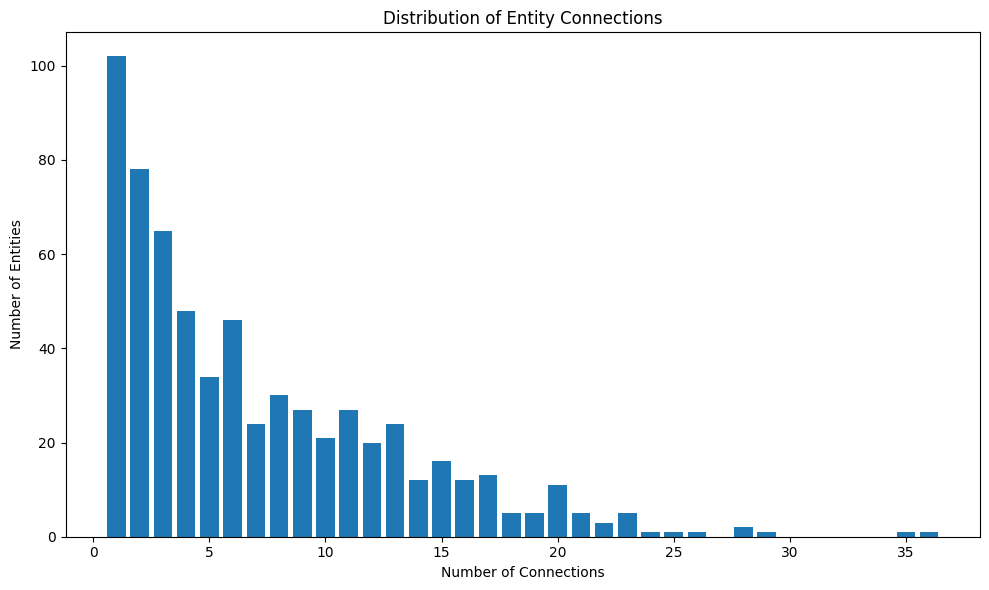

In [46]:
from collections import Counter

import matplotlib.pyplot as plt

# Count how many entities have each number of connections
connection_counts = Counter(num_connections)

# Prepare data for plotting
x = sorted(connection_counts.keys())
y = [connection_counts[k] for k in x]

plt.figure(figsize=(10, 6))
plt.bar(x, y)
plt.xlabel("Number of Connections")
plt.ylabel("Number of Entities")
plt.title("Distribution of Entity Connections")
plt.tight_layout()
plt.show()

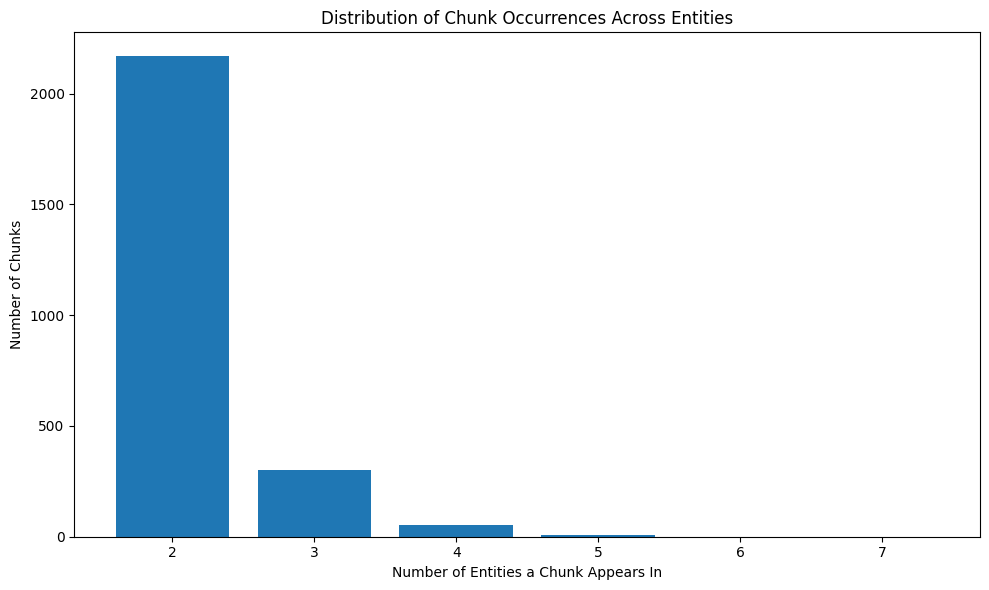

In [51]:
from collections import Counter

import matplotlib.pyplot as plt

# Count how many entities each chunk appears in
chunk_entity_counts = [len(entity_ids) for entity_ids in duplicate_chunks.values()]

# Count frequency of each "number of entities"
chunk_count_freq = Counter(chunk_entity_counts)

# Prepare data for plotting
x_chunk = sorted(chunk_count_freq.keys())
y_chunk = [chunk_count_freq[k] for k in x_chunk]

plt.figure(figsize=(10, 6))
plt.bar(x_chunk, y_chunk)
plt.xlabel("Number of Entities a Chunk Appears In")
plt.ylabel("Number of Chunks")
plt.title("Distribution of Chunk Occurrences Across Entities")
plt.tight_layout()
plt.show()

In [34]:

# Sort and select top N
sorted_indices = sorted(range(len(num_connections)), key=lambda i: num_connections[i], reverse=True)[:N]
top_entity_ids = [entity_ids[i] for i in sorted_indices]
top_num_connections = [num_connections[i] for i in sorted_indices]

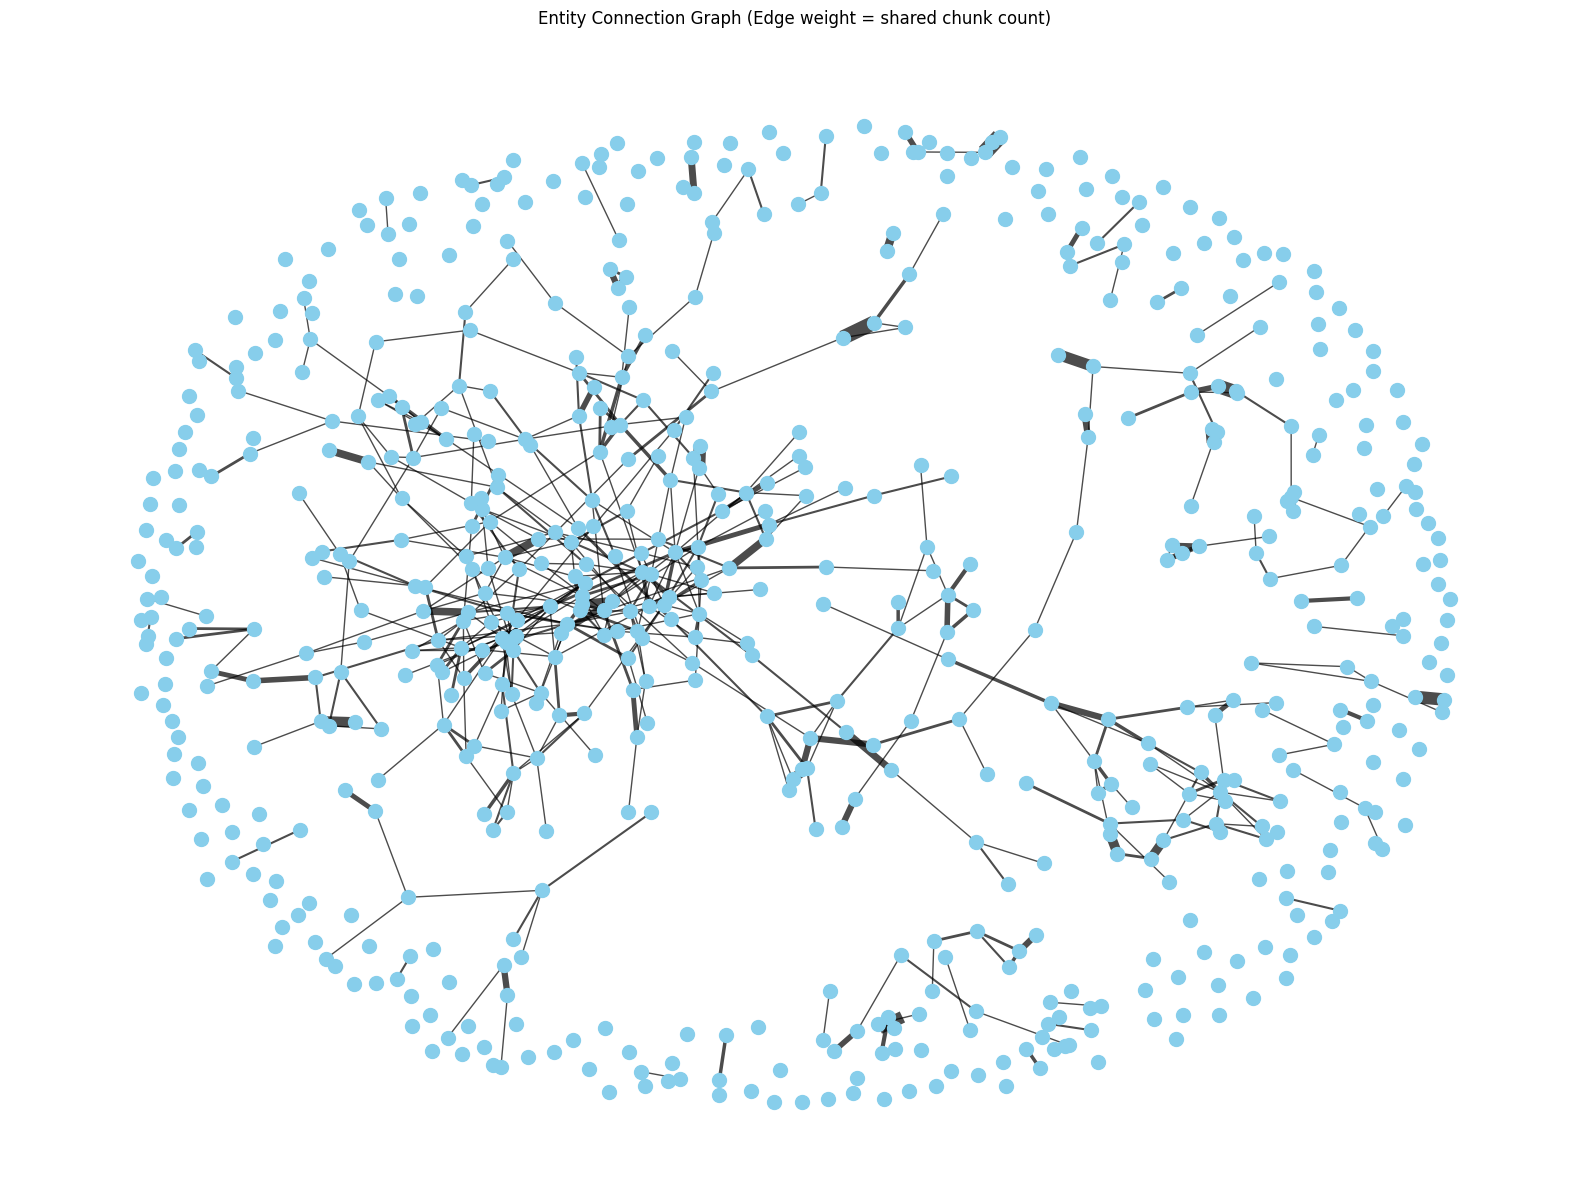

In [56]:
import networkx as nx

import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

# Add nodes (entities)
G.add_nodes_from(opp.keys())

# Add edges with weights (number of shared chunks)
for entity_id, connections in opp.items():
    for other_id, weight in connections.items():
        if weight > 1:
            G.add_edge(entity_id, other_id, weight=weight)

# Draw the graph
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=0.15, seed=42)
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]

nx.draw_networkx_nodes(G, pos, node_size=100, node_color='skyblue')
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[w/2 for w in weights], alpha=0.7)
#nx.draw_networkx_labels(G, pos, font_size=8)
# Remove node labels for a cleaner graph
# (Do not call nx.draw_networkx_labels)
plt.title("Entity Connection Graph (Edge weight = shared chunk count)")
plt.axis('off')
plt.tight_layout()
plt.show()

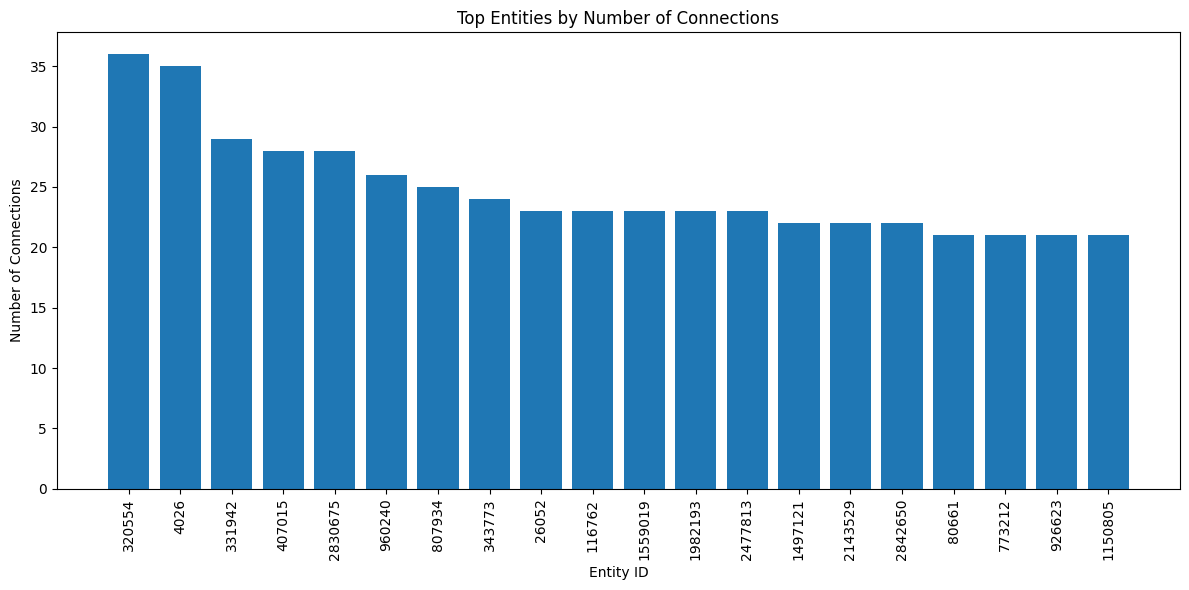

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(range(len(top_entity_ids)), top_num_connections, tick_label=top_entity_ids)
plt.xlabel("Entity ID")
plt.ylabel("Number of Connections")
plt.title("Top Entities by Number of Connections")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [41]:
average_connections = np.mean(num_connections)
print("Average number of connections per entity:", average_connections)

Average number of connections per entity: 7.0889235569422775


In [44]:
median_connections = np.median(num_connections)
print("Median number of connections per entity:", median_connections)

Median number of connections per entity: 5.0


In [45]:
num_entities_gt_10 = sum(1 for connections in opp.values() if len(connections) > 10)
print("Number of entities sharing chunks with more than 10 connections:", num_entities_gt_10)

Number of entities sharing chunks with more than 10 connections: 166


In [ ]:
important_chunks[0].keys()

dict_keys(['entity_id', 'num_chunks', 'chunks', 'chunks_lengths'])

In [ ]:
total_len = 0
for d in full_mapping:
    total_len += len(d)

total_len / 2

144866.0

In [ ]:
# with open('/home/joberant/NLP_2425b/shirab6/knowledge-analysis-suite/OLMo-core/swapping_dict.pkl', 'wb') as f:
    # pickle.dump(swapping_dict, f)

PermissionError: [Errno 13] Permission denied: '/home/joberant/NLP_2425b/shirab6/knowledge-analysis-suite/OLMo-core/swapping_dict.pkl'

In [ ]:
# To load it back later
with open('/home/joberant/NLP_2425b/shirab6/knowledge-analysis-suite/OLMo-core/swapping_dict.pkl', 'rb') as f:
    swapping_dict = pickle.load(f)

# Rebuild dataset and dataloader with swapped chunk indices

In [ ]:
tokenizer_config = TokenizerConfig.dolma2()
tokenizer = HFTokenizer(
            tokenizer_config.identifier,
            pad_token_id=tokenizer_config.pad_token_id,
            eos_token_id=tokenizer_config.eos_token_id,
            bos_token_id=tokenizer_config.bos_token_id,
        )

include_instance_metadata = False # Set to true when you want tp retrieve metadata, during training set this to False
work_dir = "/home/joberant/NLP_2425b/shirab6/knowledge-analysis-suite/OLMo-core/hp_final/dataset-cache"


dataset_config = NumpyDatasetConfig.glob(
    "/home/morg/students/gottesman3/knowledge-analysis-suite/dolma/python/final_tokenizations_with_offsets/no_special/*.npy",  # can be globs
    name=NumpyDatasetType.kas_vsl,
    max_sequence_length=2048,
    min_sequence_length=64,
    vsl_curriculum=VSLCurriculumConfig(name=VSLCurriculumType.grow_p2, num_cycles=8, balanced=False),
    tokenizer=tokenizer_config,
    work_dir=str(work_dir),
    include_instance_metadata=include_instance_metadata,
    swapping_dict = swapping_dict,
)

reordered_dataset = dataset_config.build()


Loading metadata: 100%|██████████| 8/8 [00:00<00:00, 279.79it/s]


In [ ]:
data_loader_config = NumpyDataLoaderConfig(
    global_batch_size=32768,
    seed=0,
    num_workers=8,
    prefetch_factor = 16,
)

dataloader = data_loader_config.build(reordered_dataset)
dataloader.reshuffle(1)

In [ ]:
sorted_keys = list(swapping_dict.keys())
sorted_keys.sort()